<a href="https://colab.research.google.com/github/BrianBaik/LungXRayClassifcation/blob/main/Sungmin_Baik_Lung_X_Ray_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing necessary libraries
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import gdown # for downloading from google drive

In [ ]:
# Helper function 1
def plot_digits_with_predictions(model, data, labels, img_size=128, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
# Helper function 2
def train_test_split(X,y,test_percent):
  numRows = y.shape[0]                     #number or rows in the entire dataset
  splitPoint = int((1-test_percent)*numRows)  #the row index test_size% of the way through
  p = np.random.permutation(numRows)   #array for shuffling data
  X = X[p]
  y = y[p]

  #Training data array
  X_train = X[:splitPoint]  # training features
  y_train = y[:splitPoint]  # training labels

  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  y_train = np.expand_dims(y_train,1)
  y_test = np.expand_dims(y_test,1)

  return X_train, X_test, y_train, y_test

In [ ]:
#Helper function 3: loading data
def load_lungXray_data(normal_data_loc, covid_data_loc, pneumonia_data_loc=None, opacity_data_loc=None):
    data = []
    labels = []
    for imgname in os.listdir(normal_data_loc):
        img = cv2.imread(normal_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        # Resize the image to 128x128
        img = cv2.resize(img, (128, 128))
        img = img.flatten()

        data.append(img)
        labels.append(0)

    for imgname in os.listdir(covid_data_loc):
        img = cv2.imread(covid_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        # Resize the image to 128x128
        img = cv2.resize(img, (128, 128))
        img = img.flatten()

        data.append(img)
        labels.append(1)

    if pneumonia_data_loc is not None:
      for imgname in os.listdir(pneumonia_data_loc):
        img = cv2.imread(pneumonia_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        # Resize the image to 128x128
        img = cv2.resize(img, (128, 128))
        img = img.flatten()

        data.append(img)
        labels.append(2)

    if opacity_data_loc is not None:
      for imgname in os.listdir(opacity_data_loc):
        img = cv2.imread(opacity_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        # Resize the image to 128x128
        img = cv2.resize(img, (128, 128))
        img = img.flatten()

        data.append(img)
        labels.append(3)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [ ]:
#Downloads a zip file of COVID radiographs
!gdown 1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6 -O covid.zip
!unzip /content/covid.zip
!mv /content/images /content/unhealthy/

Downloading...
From (original): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6
From (redirected): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6&confirm=t&uuid=19a0d937-d0aa-4e5a-93c5-f3ecf66d7542
To: /content/covid.zip
100% 130M/130M [00:01<00:00, 84.9MB/s]
Archive:  /content/covid.zip
   creating: images/
  inflating: images/COVID-2872.png   
  inflating: images/COVID-769.png    
  inflating: images/COVID-3259.png   
  inflating: images/COVID-182.png    
  inflating: images/COVID-3402.png   
 extracting: images/COVID-2472.png   
 extracting: images/COVID-1305.png   
  inflating: images/COVID-1877.png   
  inflating: images/COVID-233.png    
  inflating: images/COVID-2396.png   
  inflating: images/COVID-513.png    
 extracting: images/COVID-109.png    
  inflating: images/COVID-2889.png   
  inflating: images/COVID-2245.png   
  inflating: images/COVID-2834.png   
 extracting: images/COVID-2109.png   
  inflating: images/COVID-3473.png   
  inflati

In [ ]:
#Downloads a zip file of normal radiographs
!gdown 1HBaa9WgG3IHFOUYUjCEch0XPDXXZW5Sz -O normal.zip
!unzip /content/normal.zip
!mv /content/images /content/normal

Streaming output truncated to the last 5000 lines.
  inflating: images/Normal-3758.png  
  inflating: images/Normal-9943.png  
  inflating: images/Normal-8277.png  
  inflating: images/Normal-2738.png  
  inflating: images/Normal-4715.png  
  inflating: images/Normal-1181.png  
  inflating: images/Normal-6746.png  
  inflating: images/Normal-6771.png  
  inflating: images/Normal-266.png   
  inflating: images/Normal-2633.png  
  inflating: images/Normal-7675.png  
  inflating: images/Normal-4480.png  
  inflating: images/Normal-354.png   
  inflating: images/Normal-4166.png  
  inflating: images/Normal-5716.png  
  inflating: images/Normal-4920.png  
  inflating: images/Normal-2921.png  
  inflating: images/Normal-2249.png  
  inflating: images/Normal-3441.png  
  inflating: images/Normal-649.png   
  inflating: images/Normal-9136.png  
  inflating: images/Normal-3147.png  
  inflating: images/Normal-6279.png  
  inflating: images/Normal-5364.png  
  inflating: images/Normal-5526.png  

In [ ]:
#Downloads a zip file of non-COVID infection radiographs
!gdown 1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk -O otherInfection.zip
!unzip /content/otherInfection.zip
!mv /content/images/* /content/unhealthy

Streaming output truncated to the last 5000 lines.
  inflating: images/Lung_Opacity-4946.png  
  inflating: images/Lung_Opacity-526.png  
  inflating: images/Lung_Opacity-386.png  
  inflating: images/Lung_Opacity-4598.png  
  inflating: images/Lung_Opacity-4881.png  
  inflating: images/Lung_Opacity-5775.png  
  inflating: images/Lung_Opacity-1363.png  
  inflating: images/Lung_Opacity-3165.png  
  inflating: images/Lung_Opacity-5659.png  
  inflating: images/Lung_Opacity-4494.png  
  inflating: images/Lung_Opacity-5635.png  
 extracting: images/Lung_Opacity-209.png  
  inflating: images/Lung_Opacity-363.png  
 extracting: images/Lung_Opacity-3032.png  
 extracting: images/Lung_Opacity-5897.png  
  inflating: images/Lung_Opacity-4488.png  
  inflating: images/Lung_Opacity-977.png  
  inflating: images/Lung_Opacity-2020.png  
  inflating: images/Lung_Opacity-5057.png  
  inflating: images/Lung_Opacity-1849.png  
  inflating: images/Lung_Opacity-3450.png  
  inflating: images/Lung_Opaci

In [ ]:
#Downloads a zip file of viral pneumonia radiographs
!gdown 1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21 -O pneumonia.zip
!unzip /content/pneumonia.zip
!mv /content/images/* /content/unhealthy

Downloading...
From (original): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21
From (redirected): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21&confirm=t&uuid=9cf8e631-ef07-482f-ad7e-42034b2d61f8
To: /content/pneumonia.zip
100% 54.5M/54.5M [00:00<00:00, 191MB/s]
Archive:  /content/pneumonia.zip
  inflating: images/Viral Pneumonia-1106.png  
  inflating: images/Viral Pneumonia-1231.png  
  inflating: images/Viral Pneumonia-528.png  
  inflating: images/Viral Pneumonia-307.png  
  inflating: images/Viral Pneumonia-974.png  
  inflating: images/Viral Pneumonia-1144.png  
  inflating: images/Viral Pneumonia-577.png  
  inflating: images/Viral Pneumonia-76.png  
  inflating: images/Viral Pneumonia-295.png  
  inflating: images/Viral Pneumonia-1056.png  
 extracting: images/Viral Pneumonia-791.png  
  inflating: images/Viral Pneumonia-1045.png  
  inflating: images/Viral Pneumonia-497.png  
  inflating: images/Viral Pneumonia-221.png  
  inflating: images

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss


In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                   # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index] / 255.0
      y = self.output_tensor[index]

      return X, y

In [ ]:
data, labels = load_lungXray_data("normal", "unhealthy") # these are the folder names you changed the unzipped folders to


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, 0.2)

In [ ]:
import numpy as np
# Split the training data
normal_train_indices = np.where(y_train == 0)[0]
not_normal_train_indices = np.where(y_train != 0)[0]

x_train_normal = x_train[normal_train_indices]
y_train_normal = y_train[normal_train_indices]

x_train_not_normal = x_train[not_normal_train_indices]
y_train_not_normal = y_train[not_normal_train_indices]

# Split the testing data
normal_test_indices = np.where(y_test == 0)[0]
not_normal_test_indices = np.where(y_test != 0)[0]

x_test_normal = x_test[normal_test_indices]
y_test_normal = y_test[normal_test_indices]

x_test_not_normal = x_test[not_normal_test_indices]
y_test_not_normal = y_test[not_normal_test_indices]

num_normal = len(x_train_normal)
num_not_normal = len(x_train_not_normal)

In [ ]:
print(x_train_normal.shape)
print(y_train_normal.shape)
print(x_train_not_normal.shape)
print(y_train_not_normal.shape)

(8127, 16384)
(8127, 1)
(8805, 16384)
(8805, 1)


In [ ]:
training_dataset = NumpyDataset(x_train,y_train_normal)
testing_dataset = NumpyDataset(x_test,y_test)

In [ ]:
x_train_normal = x_train_normal[:num_normal]
y_train_normal = y_train_normal[:num_normal]
x_train_not_normal = x_train_not_normal[:num_normal]
y_train_not_normal = y_train_not_normal[:num_normal]

In [ ]:
print(x_train_normal.shape)
print(y_train_normal.shape)
print(x_train_not_normal.shape)
print(y_train_not_normal.shape)

(8127, 16384)
(8127, 1)
(8127, 16384)
(8127, 1)


In [ ]:
import numpy as np

# Instead of accessing attributes that don't exist, directly use the NumPy arrays
normal_data = x_train_normal
normal_label = y_train_normal  # Assuming y_train_normal contains the labels for normal data
not_healthy_data = x_train_not_normal
not_healthy_labels = y_train_not_normal # Assuming y_train_not_normal contains the labels for not_normal data

# Stack the data and labels separately
stacked_data = np.vstack((normal_data, not_healthy_data))
stacked_labels = np.vstack((normal_label, not_healthy_labels))

# Create a new NumpyDataset from the stacked data and labels
training_set_new = NumpyDataset(stacked_data, stacked_labels)

In [ ]:
# 1. Binary Classification with Logistic Regression
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h # Update flatSize to match the actual size
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x


In [ ]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

Loaded Data
Epoch [1/30], Train Loss: 0.2107, Test Loss: 0.1897
Epoch [6/30], Train Loss: 0.1654, Test Loss: 0.1651
Epoch [11/30], Train Loss: 0.1603, Test Loss: 0.1607
Epoch [16/30], Train Loss: 0.1576, Test Loss: 0.1594
Epoch [21/30], Train Loss: 0.1554, Test Loss: 0.1560
Epoch [26/30], Train Loss: 0.1541, Test Loss: 0.1546


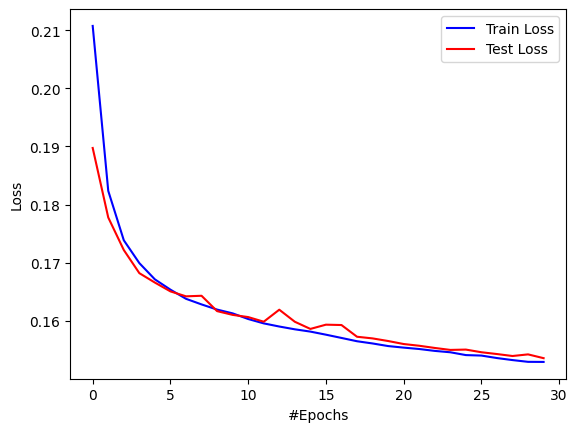

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 100

# Update image_w and image_h to match the actual image size
image_w = 128
image_h = 128

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #or torch.optim.Adam
loss_function = SigmoidLoss

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_set_new, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 12718/16254 (78.2%)

Test Set: Accuracy: 3328/4233 (78.6%)


AUC: 0.8580722907713338
Precision [0.78337408 0.78839122]
Recall [0.77578692 0.79566421]
F1 [0.77956204 0.79201102]
Count [2065 2168]


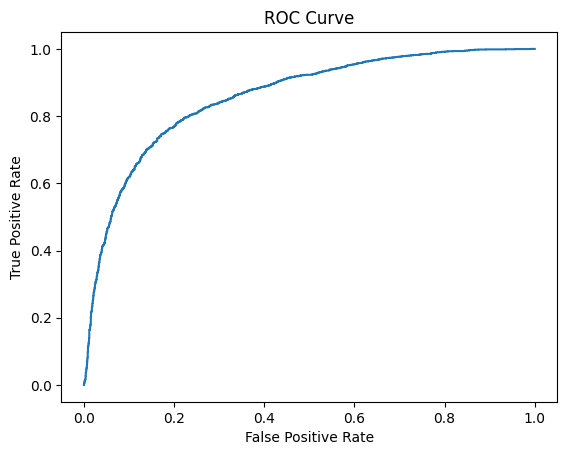

In [ ]:
from sklearn import metrics

# Calculate predictions on the entire test set
preds = model(torch.tensor(x_test).float()).detach().numpy()

# Use y_test instead of y_test_normal for ROC calculation
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
print("AUC:", metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Use y_test instead of y_test_normal for precision-recall calculation
p, r, f, count = metrics.precision_recall_fscore_support(y_test, preds > 0)
print("Precision", p)
print("Recall", r)
print("F1", f)
print("Count", count)

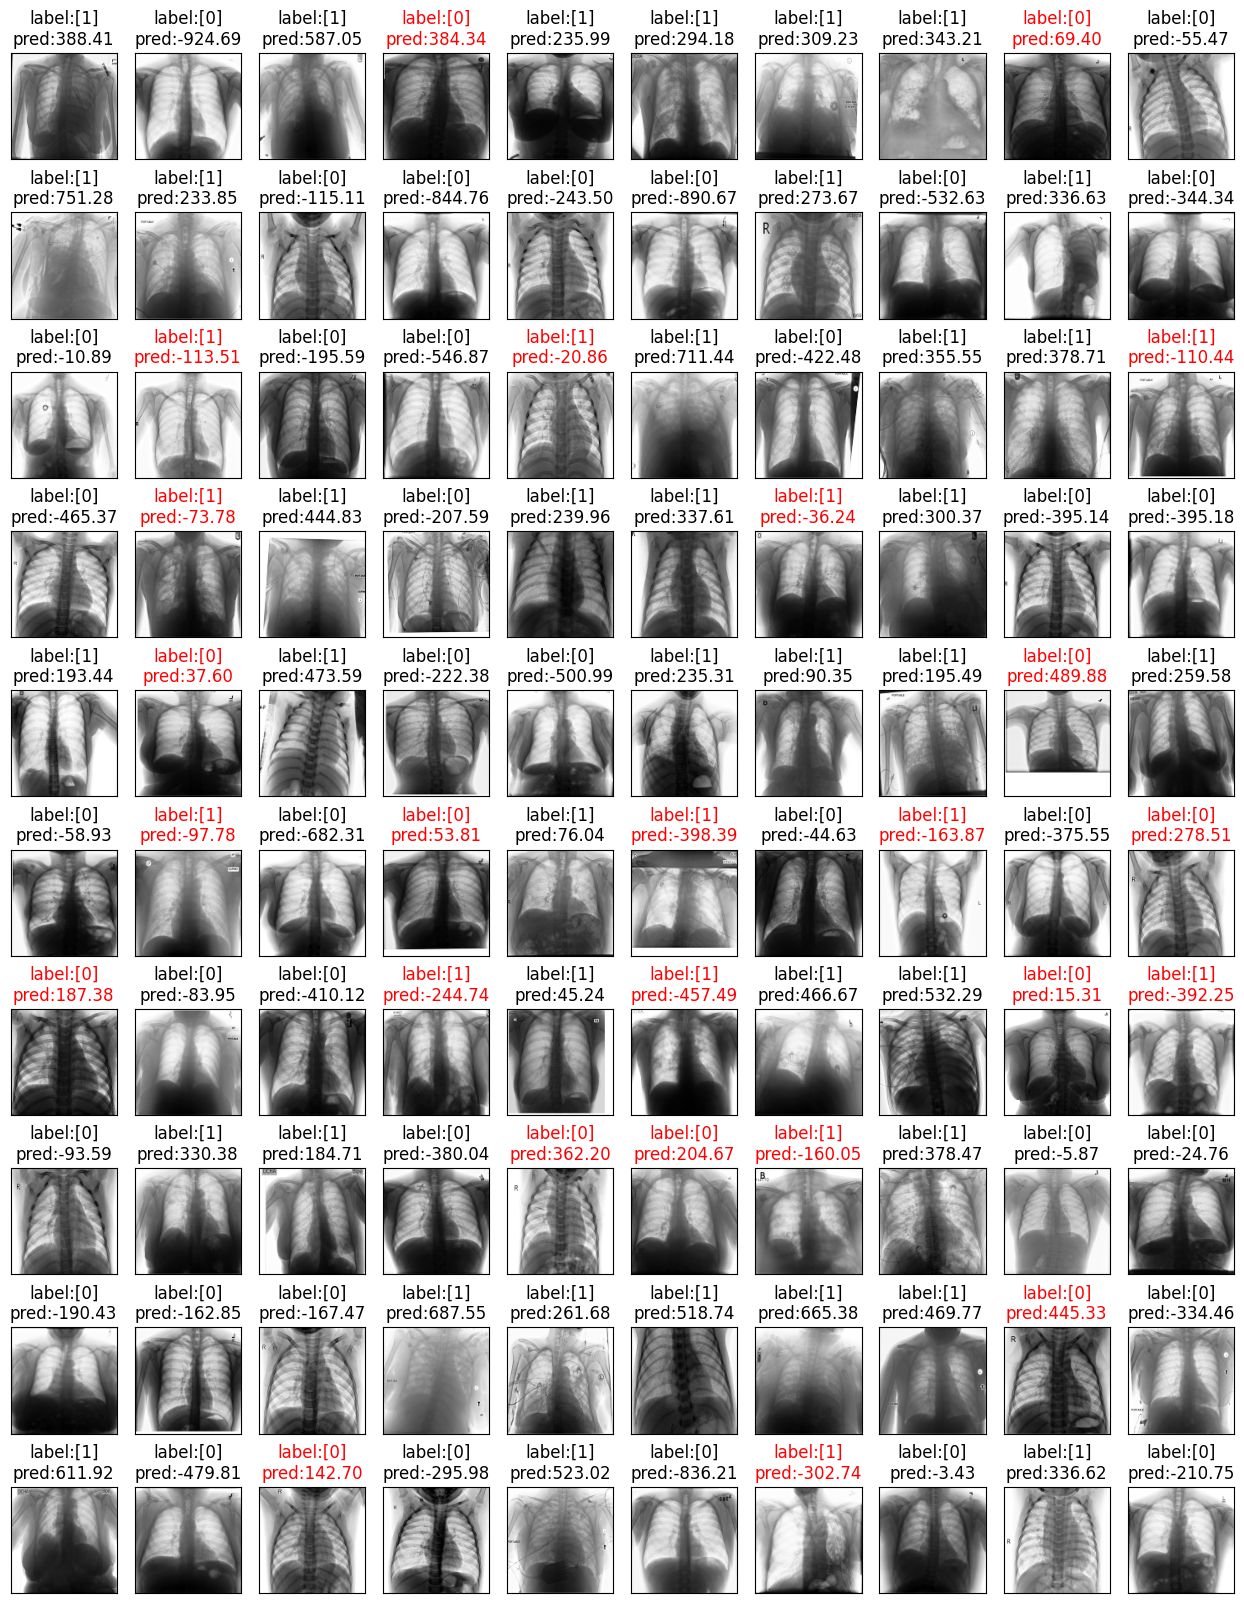

In [ ]:
plot_digits_with_predictions(model,x_test,y_test)

In [ ]:
# 2. Other Binary Classifier
# KNN

from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values for 'n_neighbors'

# Train the model
knn_classifier.fit(stacked_data, stacked_labels.ravel())

KNeighborsClassifier()

KNN Accuracy: 0.848334514528703
KNN F1-score: 0.8483703353802551
KNN AUC: 0.8488313394029824


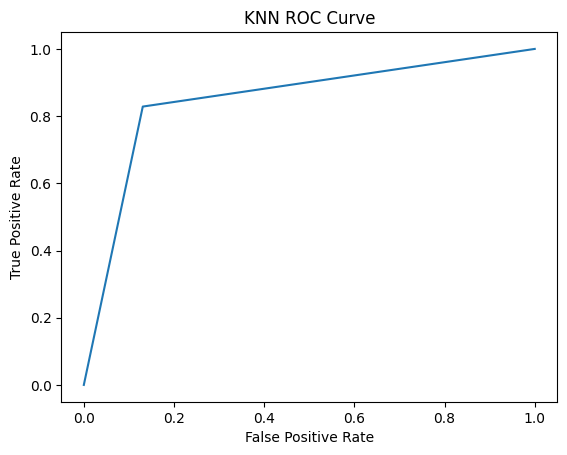

In [ ]:
import matplotlib.pyplot as plt
# Predict using the KNN classifier
knn_predictions = knn_classifier.predict(x_test)

# Calculate accuracy
knn_accuracy = metrics.accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy}")

# Calculate F1-score
knn_f1 = metrics.f1_score(y_test, knn_predictions)
print(f"KNN F1-score: {knn_f1}")


# Calculate ROC curve and AUC
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y_test, knn_predictions)
knn_auc = metrics.auc(knn_fpr, knn_tpr)
print(f"KNN AUC: {knn_auc}")

#Plot ROC Curve
plt.plot(knn_fpr, knn_tpr)
plt.title("KNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [ ]:
def knn_plot_digits_with_predictions(model, data, labels, img_size=128, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          # Use model.predict for scikit-learn models, and model() for PyTorch models
          pred_label = model.predict([data[i]])[0] if not isinstance(model, torch.nn.Module) else model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

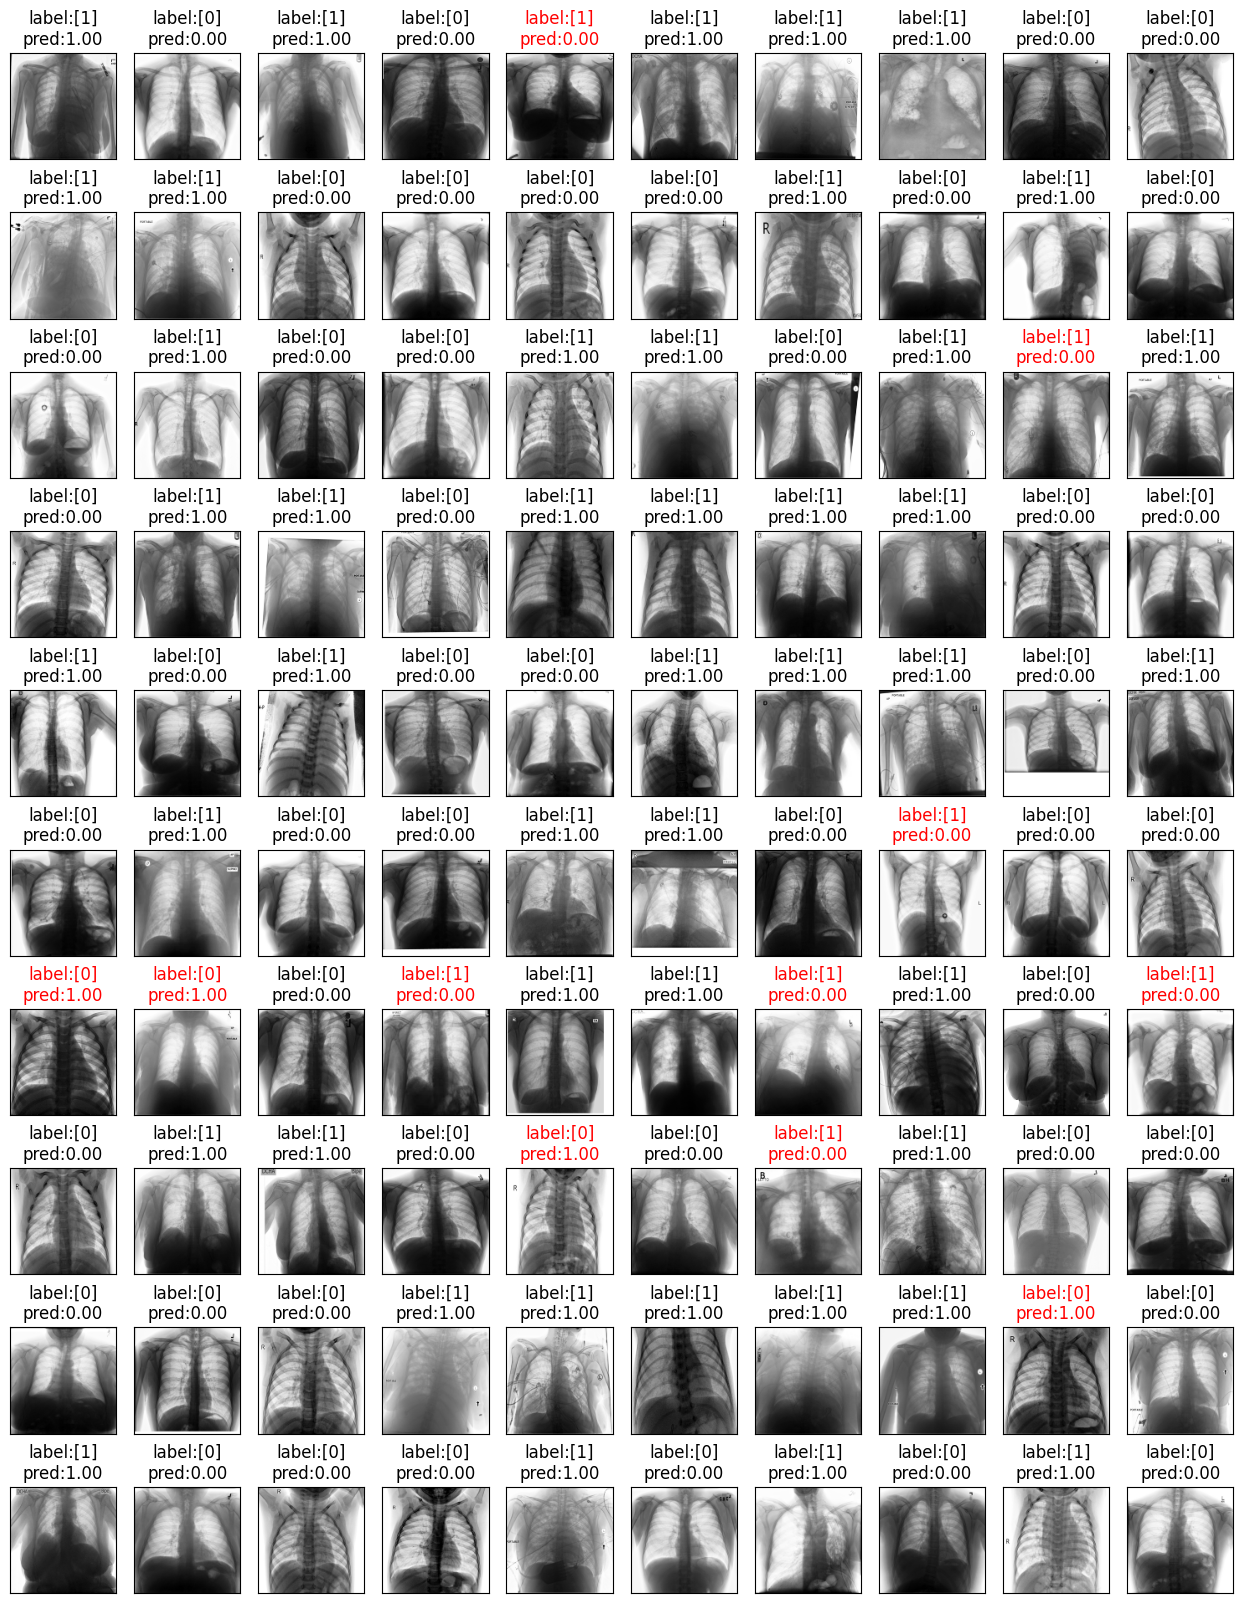

In [ ]:
knn_plot_digits_with_predictions(knn_classifier,x_test,y_test)

Decision Tree Model Metrics:
Accuracy: 0.75
F1 Score: 0.77
ROC AUC: 0.82
Precision [0.76717357 0.74118659]
Recall [0.70847458 0.79520295]
F1 [0.7366566  0.76724522]
Count [2065 2168]


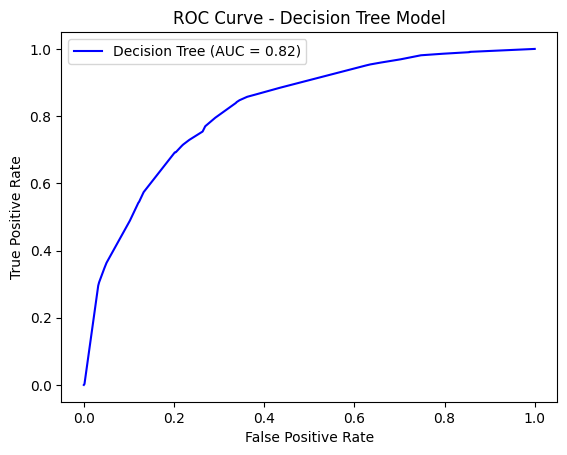

In [ ]:
# Third Binary Classifier Using Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# had to use a pipeline that first reduces dimensionality with PCA then trains a Decision Tree due to the size of the dataset and the longer runtime of the Decision Tree Classifier
pca = PCA(n_components=50, random_state=42)
#must be cautious when tuning max_depth and other parameters
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)

pipeline_tree = Pipeline([
    ('pca', pca),
    ('tree', dtree)
])

pipeline_tree.fit(x_train, y_train.ravel())
y_pred_tree = pipeline_tree.predict(x_test)
y_prob_tree = pipeline_tree.predict_proba(x_test)[:, 1]
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree= f1_score(y_test, y_pred_tree)
roc_auc_tree = roc_auc_score(y_test, y_prob_tree)

print("Decision Tree Model Metrics:")
print(f"Accuracy: {accuracy_tree:.2f}")
print(f"F1 Score: {f1_tree:.2f}")
print(f"ROC AUC: {roc_auc_tree:.2f}")

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
p_tree,r_tree,f_tree,count_tree = metrics.precision_recall_fscore_support(y_test,y_pred_tree>0)
print("Precision",p_tree)
print("Recall",r_tree)
print("F1",f_tree)
print("Count",count_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree Model")
plt.legend(loc='best')
plt.show()

In [ ]:
#Downloads a zip file of COVID radiographs
!gdown 1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6 -O covid.zip
!unzip /content/covid.zip
!mv /content/images /content/covid

Downloading...
From (original): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6
From (redirected): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6&confirm=t&uuid=552c2557-3015-44a1-8fb0-cbd0ecc82d07
To: /content/covid.zip
100% 130M/130M [00:00<00:00, 162MB/s]
Archive:  /content/covid.zip
  inflating: images/COVID-2872.png   
  inflating: images/COVID-769.png    
  inflating: images/COVID-3259.png   
  inflating: images/COVID-182.png    
  inflating: images/COVID-3402.png   
 extracting: images/COVID-2472.png   
 extracting: images/COVID-1305.png   
  inflating: images/COVID-1877.png   
  inflating: images/COVID-233.png    
  inflating: images/COVID-2396.png   
  inflating: images/COVID-513.png    
 extracting: images/COVID-109.png    
  inflating: images/COVID-2889.png   
  inflating: images/COVID-2245.png   
  inflating: images/COVID-2834.png   
 extracting: images/COVID-2109.png   
  inflating: images/COVID-3473.png   
  inflating: images/COVID-3604.

In [ ]:
#Downloads a zip file of non-COVID infection radiographs
!gdown 1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk -O otherInfection.zip
!unzip /content/otherInfection.zip
!mv /content/images /content/otherInfection

Streaming output truncated to the last 5000 lines.
  inflating: images/Lung_Opacity-4946.png  
  inflating: images/Lung_Opacity-526.png  
  inflating: images/Lung_Opacity-386.png  
  inflating: images/Lung_Opacity-4598.png  
  inflating: images/Lung_Opacity-4881.png  
  inflating: images/Lung_Opacity-5775.png  
  inflating: images/Lung_Opacity-1363.png  
  inflating: images/Lung_Opacity-3165.png  
  inflating: images/Lung_Opacity-5659.png  
  inflating: images/Lung_Opacity-4494.png  
  inflating: images/Lung_Opacity-5635.png  
 extracting: images/Lung_Opacity-209.png  
  inflating: images/Lung_Opacity-363.png  
 extracting: images/Lung_Opacity-3032.png  
 extracting: images/Lung_Opacity-5897.png  
  inflating: images/Lung_Opacity-4488.png  
  inflating: images/Lung_Opacity-977.png  
  inflating: images/Lung_Opacity-2020.png  
  inflating: images/Lung_Opacity-5057.png  
  inflating: images/Lung_Opacity-1849.png  
  inflating: images/Lung_Opacity-3450.png  
  inflating: images/Lung_Opaci

In [ ]:
#Downloads a zip file of viral pneumonia radiographs
!gdown 1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21 -O pneumonia.zip
!unzip /content/pneumonia.zip
!mv /content/images /content/pneumonia

Downloading...
From (original): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21
From (redirected): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21&confirm=t&uuid=c91c92bc-7435-4b75-97e6-70c2708646ce
To: /content/pneumonia.zip
100% 54.5M/54.5M [00:00<00:00, 229MB/s]
Archive:  /content/pneumonia.zip
   creating: images/
  inflating: images/Viral Pneumonia-1106.png  
  inflating: images/Viral Pneumonia-1231.png  
  inflating: images/Viral Pneumonia-528.png  
  inflating: images/Viral Pneumonia-307.png  
  inflating: images/Viral Pneumonia-974.png  
  inflating: images/Viral Pneumonia-1144.png  
  inflating: images/Viral Pneumonia-577.png  
  inflating: images/Viral Pneumonia-76.png  
  inflating: images/Viral Pneumonia-295.png  
  inflating: images/Viral Pneumonia-1056.png  
 extracting: images/Viral Pneumonia-791.png  
  inflating: images/Viral Pneumonia-1045.png  
  inflating: images/Viral Pneumonia-497.png  
  inflating: images/Viral Pneumonia-221.png 

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index] / 255.0
      y = self.output_tensor[index]

      return X, y

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

In [ ]:
# 3. Specific Diagnosis Classificaiton
data, labels = load_lungXray_data("normal", "covid", "pneumonia", "otherInfection")


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, 0.2)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [3],
       [0],
       [1]])

In [ ]:
# prompt: make y_train 1d array with object(int) in it where each int represents label right now y_train is 2d array make it 1d array with bunch of numbers

y_train = y_train.ravel().astype(int)
y_train
y_test = y_test.ravel().astype(int)
y_test

array([0, 0, 0, ..., 0, 3, 2])

In [ ]:
# prompt: make sure in y_train, the number of normal lung images, covid lung images, pnumonia lung images, and other infection images are the same

import numpy as np
# Count the occurrences of each label in y_train
unique_labels, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique_labels, counts))

# Find the minimum count among all labels
min_count = min(label_counts.values())

# Create lists to store the balanced data and labels
balanced_x_train = []
balanced_y_train = []

# Iterate through each label
for label in label_counts:
  # Get the indices of data points with the current label
  label_indices = np.where(y_train == label)[0]

  # Randomly sample min_count indices from the current label's indices
  sampled_indices = np.random.choice(label_indices, size=min_count, replace=False)

  # Add the corresponding data and labels to the balanced lists
  balanced_x_train.extend(x_train[sampled_indices])
  balanced_y_train.extend(y_train[sampled_indices])

# Convert the balanced lists to NumPy arrays
x_train = np.array(balanced_x_train) #Change: Assign balanced data to x_train
y_train = np.array(balanced_y_train) #Change: Assign balanced labels to y_train

# Verify the balanced counts
unique_labels_balanced, counts_balanced = np.unique(balanced_y_train, return_counts=True)
label_counts_balanced = dict(zip(unique_labels_balanced, counts_balanced))
print(label_counts_balanced)

# Create a new NumpyDataset from the balanced data and labe

{np.int64(0): np.int64(1064), np.int64(1): np.int64(1064), np.int64(2): np.int64(1064), np.int64(3): np.int64(1064)}


In [ ]:
y_train = y_train.ravel().astype(int)
y_train

array([0, 1, 0, ..., 3, 0, 1])

In [ ]:
y_test = y_test.ravel().astype(int)
y_test

array([0, 0, 0, ..., 0, 3, 2])

In [ ]:
torch.Tensor(y_train.astype(int))

tensor([0., 1., 0.,  ..., 3., 0., 1.])

In [ ]:
torch.Tensor(y_train.astype(int)).long()

tensor([0, 1, 0,  ..., 3, 0, 1])

In [ ]:
F.one_hot(torch.Tensor(torch.Tensor(y_train.astype(int))).long())

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

In [ ]:
y_train_catigories = F.one_hot(torch.Tensor(torch.Tensor(y_train.astype(int))).long())
y_test_catigories = F.one_hot(torch.Tensor(torch.Tensor(y_test.astype(int))).long())

In [ ]:
y_train_catigories

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

In [ ]:
y_test_catigories

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]])

In [ ]:
print(len(y_train))
print(len(x_test))

16932
4233


In [ ]:
training_dataset = NumpyDataset(x_train, y_train_catigories.numpy())  # Convert to NumPy array
testing_dataset = NumpyDataset(x_test, y_test_catigories.numpy())    # Convert to NumPy array

Loaded Data
Epoch [1/30], Train Loss: 0.9234, Test Loss: 0.8457
Epoch [6/30], Train Loss: 0.6698, Test Loss: 0.6721
Epoch [11/30], Train Loss: 0.6315, Test Loss: 0.6903
Epoch [16/30], Train Loss: 0.5766, Test Loss: 0.6222
Epoch [21/30], Train Loss: 0.5590, Test Loss: 0.5861
Epoch [26/30], Train Loss: 0.5601, Test Loss: 0.5919


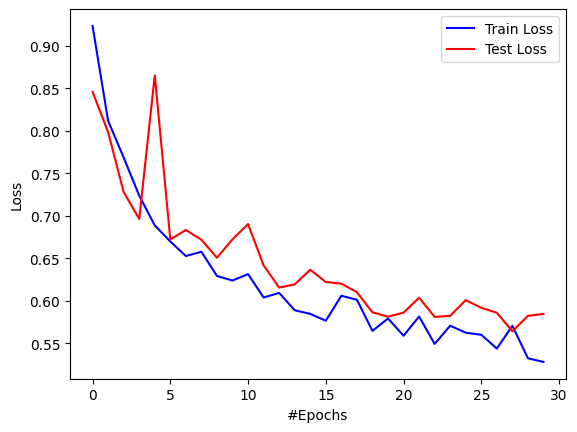

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 128
image_h = 128

#Create model
predModel = Classifier_3Layers(image_w, image_h, 4)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #NEW: Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 13469/16932 (79.5%)

Test Set: Accuracy: 3261/4233 (77.0%)


In [ ]:
def plot_digits(data,img_size=128, rows=10): # changed to 128
  fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.5, wspace=0.01)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

def plot_digits_with_multi_predictions(model, data, labels, img_size=128, rows=10): # changed to 128
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.8, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          pred_label_pro = model(torch.tensor(data[i]).float())
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)


In [ ]:
def plot_digits_with_multi_predictions_2(model, data, labels, img_size=128, rows=10): # changed to 128
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.8, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          with torch.no_grad():
            output = model(torch.tensor(data[i]).float().unsqueeze(0))
            probabilities = torch.softmax(output, dim=1)
            pred_label = torch.argmax(probabilities, dim=1).item()
            pred_probability = probabilities[0, pred_label].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          # Include the probability in the title
          axi.set_title("label:{}\npred:{}\nprob:{:.2f}".format(true_label, pred_label, pred_probability), color=drawColor)

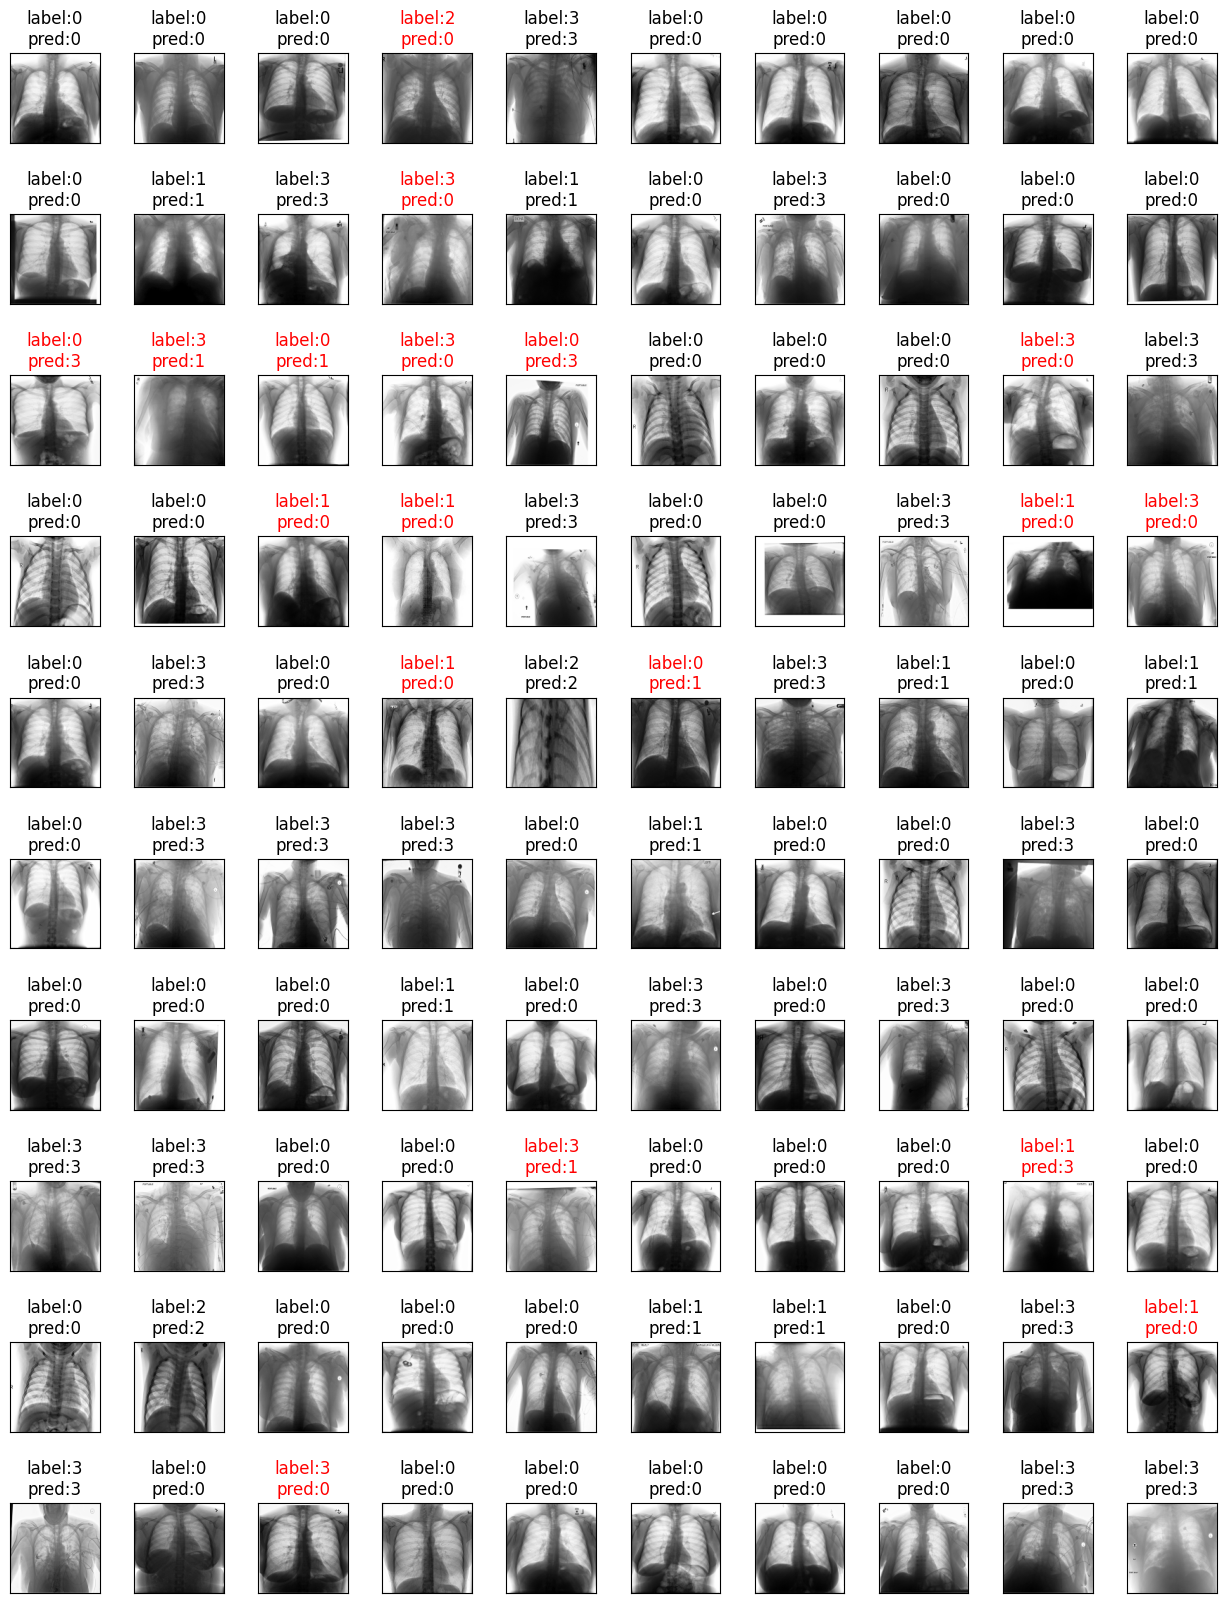

In [ ]:
plot_digits_with_multi_predictions(model, x_test, y_test_catigories)

In [ ]:
# 4. Visual Analysis
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def find_most_confident_image(model, data, labels):
  if not isinstance(data, torch.Tensor):
    data = torch.tensor(data).float()

  model.eval()
  softMaxLayer = nn.Softmax(dim=1)

  with torch.no_grad():
    output = model(data)
    probabilities = softMaxLayer(output)

  most_confident_images = {}
  for label in range(probabilities.shape[1]):
    most_confident_index = torch.argmax(probabilities[:, label]).item()
    #most_confident_image = data[most_confident_index]
    most_confident_images[label] = most_confident_index
  #result = print(most_confident_images.items(), sep='\n')

  for label, index in most_confident_images.items():
    print(f"Class {label}: Most confident image index = {index}, Confidence = {probabilities[index, label]:.4f}")
    plt.imshow(data[index].reshape(128, 128), cmap='Greys')
    plt.title(f"Class {label}: Most confident image index = {index}, Confidence = {probabilities[index, label]:.4f}")
    plt.show()

  return most_confident_images
  #plt.show() #Change: Removed extra indentation

  #return result #Change: Removed extra indentation and unnecessary return

Class 0: Most confident image index = 0, Confidence = 1.0000


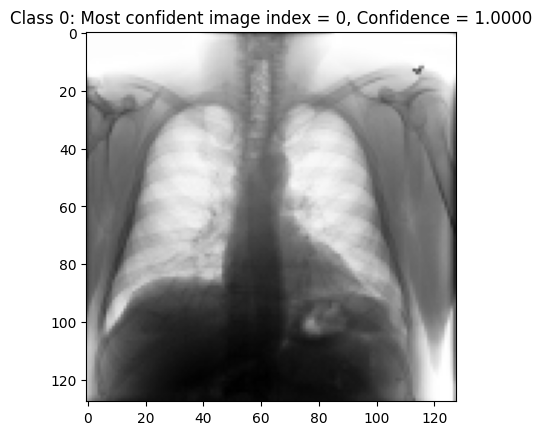

Class 1: Most confident image index = 11, Confidence = 1.0000


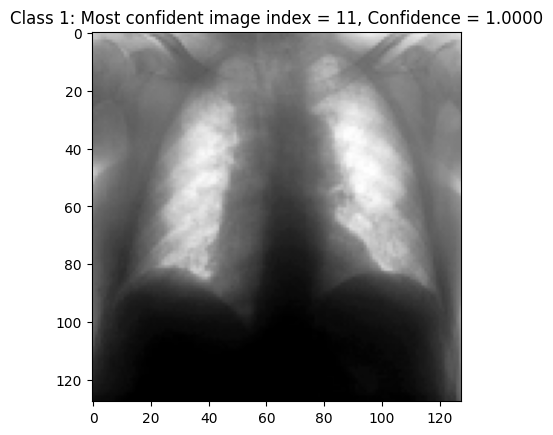

Class 2: Most confident image index = 44, Confidence = 1.0000


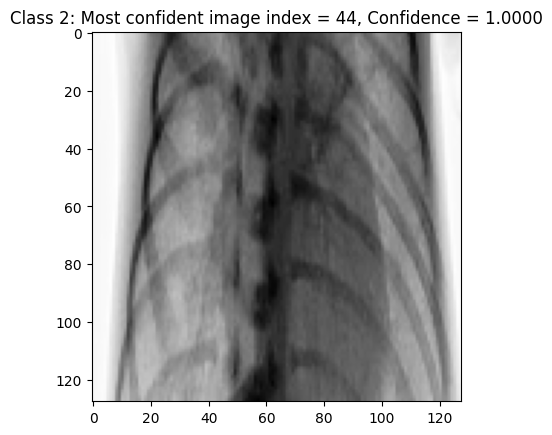

Class 3: Most confident image index = 4, Confidence = 1.0000


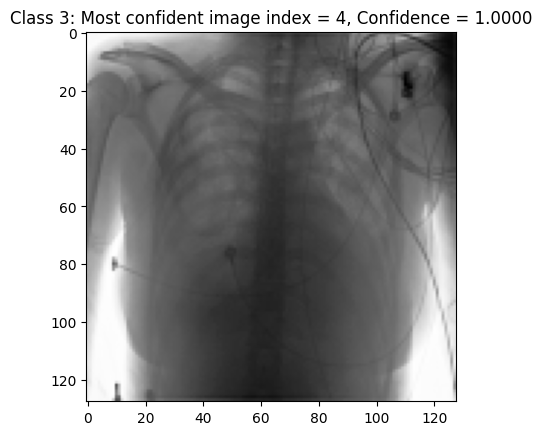

{0: 0, 1: 11, 2: 44, 3: 4}

In [ ]:
find_most_confident_image(model, x_test, y_test)

In [ ]:
# Class 0, 1, 2, and 3 represent the different categories of lung x-ray images used in the classification tasks.
# The code does not explicitly define what each class represents but from the code it appears to be:
# Class 0: Normal
# Class 1: COVID-19
# Class 2: Pneumonia
# Class 3: Other infection

Text(70.72222222222221, 0.5, 'Predicted Class')

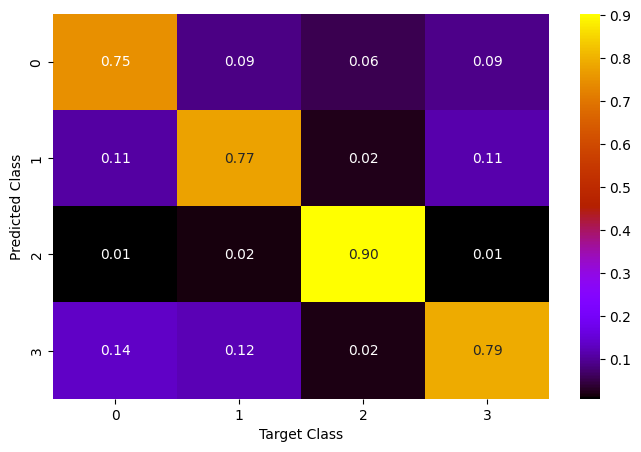

In [ ]:
from sklearn.metrics import confusion_matrix
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")